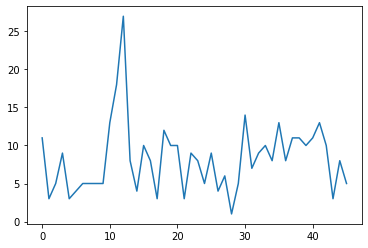

In [49]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import floor, log, sqrt
from numbers import Number
from statsmodels.graphics.tsaplots import plot_acf
import pymc3 as pm
import arviz as az
chptdat = pd.read_table("COUP551_rates.dat", sep="\s+", usecols=[0, 1], names = ["Time Bin", "Counts"], header=0)
Y = chptdat['Counts']
plt.plot(Y)

In [50]:
def mhsampler_2changep(NUMIT=1000, dat=Y, init_T1=1, init_T2=1, init_T3 = 1,init_K1=10,init_K2 = 20, init_B1=1, init_B2=1,init_B3=1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((8, NUMIT))
 # count number of accepted proposals (for k only)
    acc_1= 0
    acc_2 = 0
    
    # starting values for markov chain
    mchain[:,0] = np.array([init_T1, init_T2, init_T3, init_K1,init_K2, init_B1, init_B2, init_B3])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currlambda_1 = mchain[0, i-1]
        currlambda_2 = mchain[1, i-1]
        currlambda_3 = mchain[2, i-1]
        currk_1 = mchain[3, i-1]
        currk_2 = mchain[4, i-1]
        currb1 = mchain[5, i-1]
        currb2 = mchain[6, i-1]
        currb3 = mchain[7, i-1]
        # sample from full conditional distribution of theta (Gibbs update)
        currlambda_1 = np.random.gamma(shape=sum(Y.iloc[:int(currk_1)])+0.5, scale=currb1/(currk_1*currb1 + 1))
        currlambda_2 = np.random.gamma(shape=sum(Y.iloc[int(currk_1):int(currk_2)])+0.5, scale=currb2/((currk_2-currk_1)*currb2+1))
        currlambda_3 = np.random.gamma(shape=sum(Y.iloc[int(currk_2):])+0.5, scale=currb3/((n - currk_2)*currb3 + 1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_1 = np.random.randint(1, currk_2)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk_1)])*log(currlambda_1) + sum(Y.iloc[int(propk_1):int(currk_2)])*log(currlambda_2) - propk_1*currlambda_1 
                     - (currk_2-propk_1)*currlambda_2 +(log(1/(45-currk_1))) - (sum(Y.iloc[:int(currk_1)])*log(currlambda_1) + sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) 
                                               - currk_1*currlambda_1 - (currk_2-currk_1)*currlambda_2 + (log(1/(45-propk_1)))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_1 += 1
            currk_1 = propk_1
            

        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_2 = np.random.randint(currk_1+1, 45)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(propk_1):int(propk_2)])*log(currlambda_2) + sum(Y.iloc[int(propk_2):])*log(currlambda_3) - propk_2*currlambda_2 
                     - (n-propk_2)*currlambda_3+(log(1/(currk_2))) - (sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) + sum(Y.iloc[int(currk_2):])*log(currlambda_3) 
                                               - currk_2*currlambda_2 - (n-currk_2)*currlambda_3+(log(1/(propk_2)))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_2 += 1
            currk_2 = propk_2


        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_1+1))
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_2+1))
        currb3 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_3+1))
        
        
        # update chain with new values
        mchain[:,i] = np.array([currlambda_1, currlambda_2,currlambda_3, currk_1,currk_2, currb1, currb2, currb3])
        
    return mchain

In [52]:
mchain1 = mhsampler_2changep(NUMIT = 100000)

print("Mean of row (theta) is now", np.mean(mchain1[0,95000:]))
print("Mean of row (theta)is now", np.mean(mchain1[1,95000:]))
print("Mean of row (theta)is now", np.mean(mchain1[2,95000:]))
print("Mean of row cps is now", np.mean(mchain1[3,95000:]))
print("Mean of row cps is now", np.mean(mchain1[4,95000:]))
print("Mean of row b is now", np.mean(mchain1[5,95000:]))
print("Mean of row b is now", np.mean(mchain1[6,95000:]))
print("Mean of row b is now", np.mean(mchain1[7,95000:]))

print("Median of row (theta) is now", np.median(mchain1[0,95000:]))
print("Median of row (theta)is now", np.median(mchain1[1,95000:]))
print("Median of row (theta)is now", np.median(mchain1[2,95000:]))
print("Median of row cps is now", np.median(mchain1[3,95000:]))
print("Median of row cps is now", np.median(mchain1[4,95000:]))
print("Median of row b is now", np.median(mchain1[5,95000:]))
print("Median of row b is now", np.median(mchain1[6,95000:]))
print("Median of row b is now", np.median(mchain1[7,95000:]))

y1 = np.apply_along_axis(np.mean, 1, mchain1)

n= 46
Mean of row (theta) is now 6.174970436685909
Mean of row (theta)is now 9.093877975639533
Mean of row (theta)is now 8.38868619391652
Mean of row cps is now 8.7664
Mean of row cps is now 27.2412
Mean of row b is now 14486643.613139916
Mean of row b is now 49724.37902387742
Mean of row b is now 24749.915832230105
Median of row (theta) is now 5.718074241595633
Median of row (theta)is now 9.034608255784235
Median of row (theta)is now 8.563250393023797
Median of row cps is now 10.0
Median of row cps is now 29.0
Median of row b is now 31.11380298786337
Median of row b is now 44.92982522185119
Median of row b is now 42.47920506112996


In [ ]:
plot_acf(mchain1[0,495000:])
plot_acf(mchain1[1,495000:])
plot_acf(mchain1[2,495000:])
plot_acf(mchain1[3,495000:])
plot_acf(mchain1[4,495000:])
plot_acf(mchain1[5,495000:])
plot_acf(mchain1[6,495000:])
plot_acf(mchain1[7,495000:])


In [ ]:
def mhsampler_3changep(NUMIT=1000, dat=Y, init_T1=1, init_T2=1, init_T3 = 1,init_T4 = 1,init_K1=10,init_K2 = 20, init_K3 = 30,init_B1=1, init_B2=1,init_B3=1,init_B4 =1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((11, NUMIT))
 # count number of accepted proposals (for k only)
    acc_1= 0
    acc_2 = 0
    acc_3 = 0
    
    # starting values for markov chain
    mchain[:,0] = np.array([init_T1, init_T2, init_T3, init_T4,init_K1,init_K2,init_K3 ,init_B1, init_B2, init_B3, init_B4])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currlambda_1 = mchain[0, i-1]
        currlambda_2 = mchain[1, i-1]
        currlambda_3 = mchain[2, i-1]
        currlambda_4 = mchain[3, i-1]
        currk_1 = mchain[4, i-1]
        currk_2 = mchain[5, i-1]
        currk_3 = mchain[6, i-1]
        currb1 = mchain[7, i-1]
        currb2 = mchain[8, i-1]
        currb3 = mchain[9, i-1]
        currb4 = mchain[10, i-1]
        # sample from full conditional distribution of theta (Gibbs update)
        currlambda_1 = np.random.gamma(shape=sum(Y.iloc[:int(currk_1)])+0.5, scale=currb1/(currk_1*currb1 + 1))
        currlambda_2 = np.random.gamma(shape=sum(Y.iloc[int(currk_1):int(currk_2)])+0.5, scale=currb2/((currk_2-currk_1)*currb2+1))
        currlambda_3 = np.random.gamma(shape=sum(Y.iloc[int(currk_2):int(currk_3)])+0.5, scale=currb3/((currk_3 - currk_2)*currb3 + 1))
        currlambda_4 = np.random.gamma(shape=sum(Y.iloc[int(currk_3):])+0.5, scale=currb4/((n - currk_3)*currb4 + 1))
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_1 = np.random.randint(1, currk_2)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk_1)])*log(currlambda_1) + sum(Y.iloc[int(propk_1):int(currk_2)])*log(currlambda_2) - propk_1*currlambda_1 
                     - (currk_2-propk_1)*currlambda_2 + log(1/(currk_3 - currk_1)) - (sum(Y.iloc[:int(currk_1)])*log(currlambda_1) + sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) 
                                               - currk_1*currlambda_1 - (currk_2-currk_1)*currlambda_2+log(1/(currk_3 - propk_1))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_1 += 1
            currk_1 = propk_1
            

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_2 = np.random.randint(currk_1+1, currk_3)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(propk_1):int(propk_2)])*log(currlambda_2) + sum(Y.iloc[int(propk_2):int(currk_3)])*log(currlambda_3) - propk_2*currlambda_2 
                     - (currk_3-propk_2)*currlambda_3 + log(1/(currk_2))+log(1/(45-currk_2)) - (sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) + sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) 
                                               - currk_2*currlambda_2 - (currk_3-currk_2)*currlambda_3+log(1/(propk_2))+log(1/(45-propk_2)) ))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_2 += 1
            currk_2 = propk_2

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_3 = np.random.randint(currk_2+1, 45)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(propk_2):int(propk_3)])*log(currlambda_3) + sum(Y.iloc[int(propk_3):])*log(currlambda_4) - propk_3*currlambda_3 
                     - (n-propk_3)*currlambda_4+log(1/(currk_3-currk_1)) - (sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) + sum(Y.iloc[int(currk_3):])*log(currlambda_4) 
                                               - currk_3*currlambda_3 - (n-currk_3)*currlambda_4+log(1/(propk_3-currk_1))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_3 += 1
            currk_3 = propk_3
        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_1+1))
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_2+1))
        currb3 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_3+1))
        currb4 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_4+1))
        
        
        # update chain with new values
        mchain[:,i] = np.array([currlambda_1, currlambda_2,currlambda_3,currlambda_4 ,currk_1,currk_2, currk_3,currb1, currb2, currb3, currb4])
        
    return mchain

In [53]:
mchain2 = mhsampler_3changep(NUMIT = 100000)

print("Mean of row (theta) is now", np.mean(mchain2[0,95000:]))
print("Mean of row (theta)is now", np.mean(mchain2[1,95000:]))
print("Mean of row (theta)is now", np.mean(mchain2[2,95000:]))
print("Mean of row (theta)is now", np.mean(mchain2[3,95000:]))
print("Mean of row cps is now", np.mean(mchain2[4,95000:]))
print("Mean of row cps is now", np.mean(mchain2[5,95000:]))
print("Mean of row cps is now", np.mean(mchain2[6,95000:]))
print("Mean of row b is now", np.mean(mchain2[7,95000:]))
print("Mean of row b is now", np.mean(mchain2[8,95000:]))
print("Mean of row b is now", np.mean(mchain2[9,95000:]))
print("Mean of row b is now", np.mean(mchain2[10,95000:]))

print("Median of row (theta) is now", np.median(mchain2[0,95000:]))
print("Median of row (theta)is now", np.median(mchain2[1,95000:]))
print("Median of row (theta)is now", np.median(mchain2[2,95000:]))
print("Median of row (theta)is now", np.median(mchain2[3,95000:]))
print("Median of row cps is now", np.median(mchain2[4,95000:]))
print("Median of row cps is now", np.median(mchain2[5,95000:]))
print("Median of row cps is now", np.median(mchain2[6,95000:]))
print("Median of row b is now", np.median(mchain2[7,95000:]))
print("Median of row b is now", np.median(mchain2[8,95000:]))
print("Median of row b is now", np.median(mchain2[9,95000:]))
print("Median of row b is now", np.median(mchain2[10,95000:]))

y2 = np.apply_along_axis(np.mean, 1, mchain2)
print(y2)

n= 46
Mean of row (theta) is now 6.45324695140237
Mean of row (theta)is now 9.073575226106552
Mean of row (theta)is now 8.868456610841804
Mean of row (theta)is now 8.036866562591516
Mean of row cps is now 8.0546
Mean of row cps is now 21.7796
Mean of row cps is now 34.9438
Mean of row b is now 325802534.54338336
Mean of row b is now 62331.82264673588
Mean of row b is now 385290.09342374513
Mean of row b is now 270667.81331249763
Median of row (theta) is now 5.7698441006195385
Median of row (theta)is now 9.072579216665037
Median of row (theta)is now 8.754178383166028
Median of row (theta)is now 8.36846403077342
Median of row cps is now 10.0
Median of row cps is now 21.0
Median of row cps is now 37.0
Median of row b is now 31.95075866729807
Median of row b is now 40.42238586667841
Median of row b is now 38.94445735280864
Median of row b is now 38.44882898112873
[6.44359397e+00 9.26722528e+00 8.99580394e+00 7.98408121e+00
 8.12375000e+00 2.17704400e+01 3.50992300e+01 1.73459789e+07
 2.070

In [ ]:
plot_acf(mchain2[0,99000:])
plot_acf(mchain2[1,99000:])
plot_acf(mchain2[2,99000:])
plot_acf(mchain2[3,99000:])
plot_acf(mchain2[4,99000:])
plot_acf(mchain2[5,99000:])
plot_acf(mchain2[6,99000:])
plot_acf(mchain2[7,99000:])
plot_acf(mchain2[8,99000:])
plot_acf(mchain2[9,99000:])
plot_acf(mchain2[10,99000:])

In [ ]:
def mhsampler_4changep(NUMIT=1000, dat=Y, init_T1=1, init_T2=1, init_T3 = 1,init_T4 = 1,init_T5 = 1,init_K1=1,init_K2 = 10, init_K3 =20,init_K4 = 30,init_B1=1, init_B2=1,init_B3=1,init_B4 =1, init_B5 = 1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((14, NUMIT))
    # count number of accepted proposals (for k only)
    acc_1= 0
    acc_2 = 0
    acc_3 = 0
    acc_4 = 0
    # starting values for markov chain
    mchain[:,0] = np.array([init_T1, init_T2, init_T3, init_T4, init_T5, init_K1, init_K2, init_K3,init_K4,init_B1, init_B2, init_B3, init_B4, init_B5])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currlambda_1 = mchain[0, i-1]
        currlambda_2 = mchain[1, i-1]
        currlambda_3 = mchain[2, i-1]
        currlambda_4 = mchain[3, i-1]
        currlambda_5 = mchain[4, i-1]
        currk_1 = mchain[5, i-1]
        currk_2 = mchain[6, i-1]
        currk_3 = mchain[7, i-1]
        currk_4 = mchain[8, i-1]
        currb1 = mchain[9, i-1]
        currb2 = mchain[10, i-1]
        currb3 = mchain[11, i-1]
        currb4 = mchain[12, i-1]
        currb5 = mchain[13, i-1]
        # sample from full conditional distribution of theta (Gibbs update)
        currlambda_1 = np.random.gamma(shape=sum(Y.iloc[:int(currk_1)])+0.5, scale=currb1/(currk_1*currb1 + 1))
        currlambda_2 = np.random.gamma(shape=sum(Y.iloc[int(currk_1):int(currk_2)])+0.5, scale=currb2/((currk_2-currk_1)*currb2+1))
        currlambda_3 = np.random.gamma(shape=sum(Y.iloc[int(currk_2):int(currk_3)])+0.5, scale=currb3/((currk_3 - currk_2)*currb3 + 1))
        currlambda_4 = np.random.gamma(shape=sum(Y.iloc[int(currk_3):int(currk_4)])+0.5, scale=currb4/((currk_4 - currk_3)*currb4 + 1))
        currlambda_5 = np.random.gamma(shape=sum(Y.iloc[int(currk_4):])+0.5, scale=currb5/((n - currk_4)*currb5 + 1))
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_1 = np.random.randint(1, currk_2)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk_1)])*log(currlambda_1) + sum(Y.iloc[int(propk_1):int(currk_2)])*log(currlambda_2) - propk_1*currlambda_1 
                     - (currk_2-propk_1)*currlambda_2 + log(1/(currk_3 - currk_1)) - (sum(Y.iloc[:int(currk_1)])*log(currlambda_1) + sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) 
                                               - currk_1*currlambda_1 - (currk_2-currk_1)*currlambda_2+log(1/(currk_3 - propk_1))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_1 += 1
            currk_1 = propk_1
            

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_2 = np.random.randint(currk_1+1, currk_3)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_1):int(propk_2)])*log(currlambda_2) + sum(Y.iloc[int(propk_2):int(currk_3)])*log(currlambda_3) - propk_2*currlambda_2 
                     - (currk_3-propk_2)*currlambda_3 + log(1/(currk_2)) + log(1/(currk_4 - currk_2)) - (sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) + sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) 
                                               - currk_2*currlambda_2 - (currk_3-currk_2)*currlambda_3+log(1/(propk_2)) + log(1/(currk_4 - propk_2))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_2 += 1
            currk_2 = propk_2

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_3 = np.random.randint(currk_2+1, currk_4)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_2):int(propk_3)])*log(currlambda_3) + sum(Y.iloc[int(propk_3):int(currk_4)])*log(currlambda_4) - propk_3*currlambda_3 
                     - (currk_4-propk_3)*currlambda_4 + log(1/(currk_3-currk_1)) + log(1/(45-currk_3))- (sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) + sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) 
                                               - currk_3*currlambda_3 - (currk_4-currk_3)*currlambda_4+log(1/(propk_3-currk_1))+ log(1/(45-propk_3))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_3 += 1
            currk_3 = propk_3
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_4 = np.random.randint(currk_3+1, 45)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_3):int(propk_4)])*log(currlambda_5) + sum(Y.iloc[int(propk_4):])*log(currlambda_5) - propk_4*currlambda_4 
                     - (n-propk_4)*currlambda_5 +log(1/(currk_4- currk_2))- (sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) + sum(Y.iloc[int(currk_4):])*log(currlambda_5) 
                                               - currk_4*currlambda_4 - (n-currk_4)*currlambda_5+log(1/(propk_4- currk_2))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_4 += 1
            currk_4 = propk_4
        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_1+1))
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_2+1))
        currb3 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_3+1))
        currb4 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_4+1))
        currb5 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_5+1))
        
        
        # update chain with new values
        mchain[:,i] = np.array([currlambda_1, currlambda_2,currlambda_3,currlambda_4,currlambda_5 ,currk_1,currk_2, currk_3,currk_4,currb1, currb2, currb3, currb4, currb5])
        
    return mchain

In [63]:
mchain3 = mhsampler_4changep(NUMIT = 500000)
print("Mean of row (theta) is now", np.mean(mchain3[0,95000:]))
print("Mean of row (theta)is now", np.mean(mchain3[1,95000:]))
print("Mean of row (theta)is now", np.mean(mchain3[2,95000:]))
print("Mean of row (theta)is now", np.mean(mchain3[3,95000:]))
print("Mean of row (theta)is now", np.mean(mchain3[4,95000:]))
print("Mean of row cps is now", np.mean(mchain3[5,95000:]))
print("Mean of row cps is now", np.mean(mchain3[6,95000:]))
print("Mean of row cps is now", np.mean(mchain3[7,95000:]))
print("Mean of row cps is now", np.mean(mchain3[8,95000:]))
print("Mean of row b is now", np.mean(mchain3[9,95000:]))
print("Mean of row b is now", np.mean(mchain3[10,95000:]))
print("Mean of row b is now", np.mean(mchain3[11,95000:]))
print("Mean of row b is now", np.mean(mchain3[12,95000:]))
print("Mean of row b is now", np.mean(mchain3[13,95000:]))

print("Median of row (theta) is now", np.median(mchain3[0,95000:]))
print("Median of row (theta)is now", np.median(mchain3[1,95000:]))
print("Median of row (theta)is now", np.median(mchain3[2,95000:]))
print("Median of row (theta)is now", np.median(mchain3[3,95000:]))
print("Median of row (theta)is now", np.median(mchain3[4,95000:]))
print("Median of row cps is now", np.median(mchain3[5,95000:]))
print("Median of row cps is now", np.median(mchain3[6,95000:]))
print("Median of row cps is now", np.median(mchain3[7,95000:]))
print("Median of row cps is now", np.median(mchain3[8,95000:]))
print("Median of row b is now", np.median(mchain3[9,95000:]))
print("Median of row b is now", np.median(mchain3[10,95000:]))
print("Median of row b is now", np.median(mchain3[11,95000:]))
print("Median of row b is now", np.median(mchain3[12,95000:]))
print("Median of row b is now", np.median(mchain3[13,95000:]))
y3 = np.apply_along_axis(np.mean, 1, mchain3)

n= 46
Mean of row (theta) is now 5.956554827713819
Mean of row (theta)is now 18.31157668634031
Mean of row (theta)is now 8.485841574585198
Mean of row (theta)is now 10.013357792146595
Mean of row (theta)is now 6.062440891327401
Mean of row cps is now 9.440197530864198
Mean of row cps is now 12.74226913580247
Mean of row cps is now 28.84262962962963
Mean of row cps is now 41.52455555555556
Mean of row b is now 16970066.588481482
Mean of row b is now 16057855.92912045
Mean of row b is now 14097782151.14576
Mean of row b is now 28631122.386710405
Mean of row b is now 216317430.7342955
Median of row (theta) is now 5.652969581653226
Median of row (theta)is now 19.106213636412612
Median of row (theta)is now 7.138173903875174
Median of row (theta)is now 10.070810892095395
Median of row (theta)is now 5.8271918792397415
Median of row cps is now 10.0
Median of row cps is now 13.0
Median of row cps is now 30.0
Median of row cps is now 43.0
Median of row b is now 30.03475123432015
Median of row b 

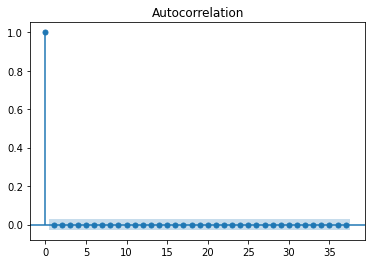

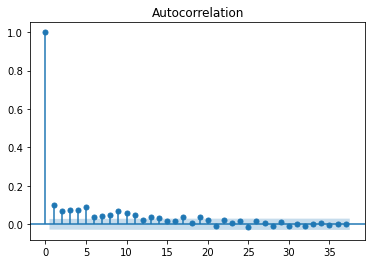

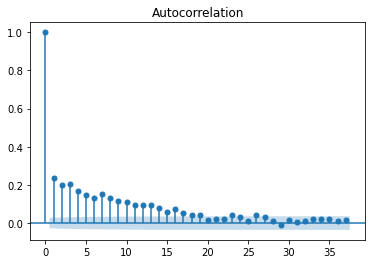

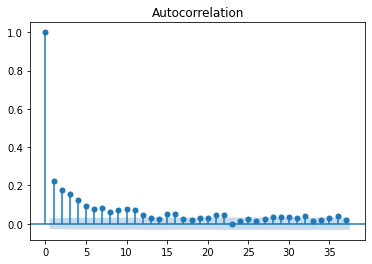

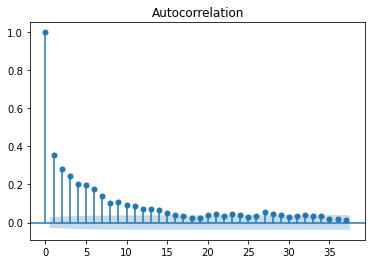

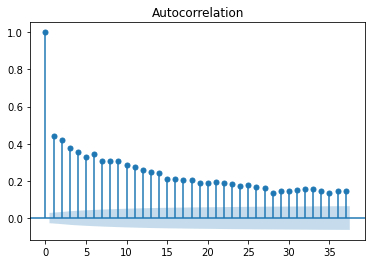

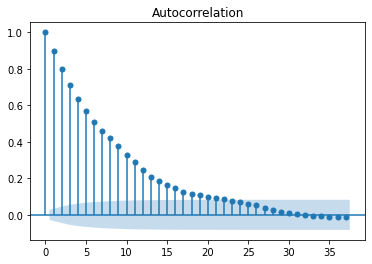

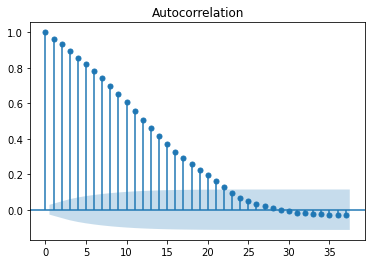

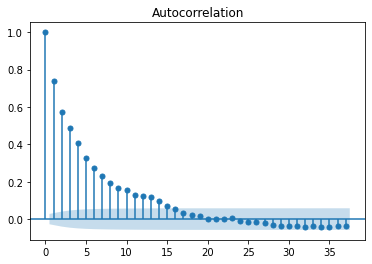

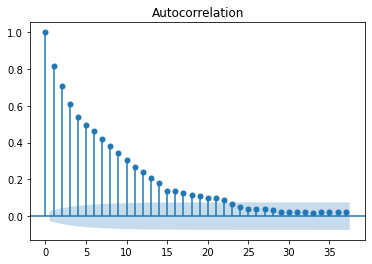

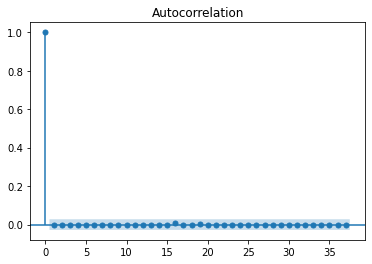

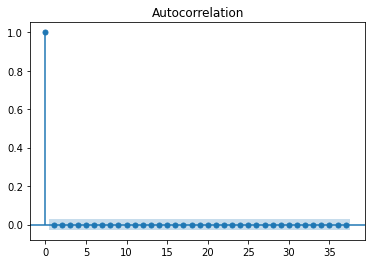

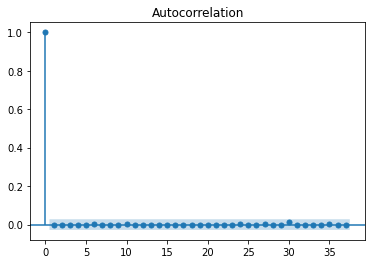

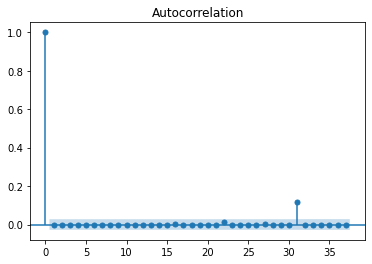

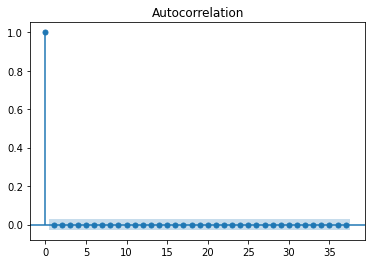

In [61]:
plot_acf(mchain3[0,95000:])
plot_acf(mchain3[1,95000:])
plot_acf(mchain3[2,95000:])
plot_acf(mchain3[3,95000:])
plot_acf(mchain3[4,95000:])
plot_acf(mchain3[5,95000:])
plot_acf(mchain3[6,95000:])
plot_acf(mchain3[7,95000:])
plot_acf(mchain3[8,95000:])
plot_acf(mchain3[9,95000:])
plot_acf(mchain3[10,95000:])
plot_acf(mchain3[11,95000:])
plot_acf(mchain3[12,95000:])
plot_acf(mchain3[13,95000:])



In [ ]:
def mhsampler_5changep(NUMIT=1000, dat=Y, init_T1=1, init_T2=1, init_T3 = 1,init_T4 = 1,init_T5 = 1,init_T6=1,init_K1=1,init_K2 = 10, init_K3 =20, init_K4 = 30, init_K5=40,init_B1=1, init_B2=1,init_B3=1,init_B4 =1, init_B5 = 1, init_B6 = 1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((17, NUMIT))
# count number of accepted proposals (for k only)
    acc_1 = 0
    acc_2 = 0
    acc_3 = 0
    acc_4 = 0
    acc_5 = 0
    # starting values for markov chain
    mchain[:,0] = np.array([init_T1, init_T2, init_T3, init_T4, init_T5, init_T6,init_K1, init_K2, init_K3,init_K4,init_K5,init_B1, init_B2, init_B3, init_B4, init_B5,init_B6])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currlambda_1 = mchain[0, i-1]
        currlambda_2 = mchain[1, i-1]
        currlambda_3 = mchain[2, i-1]
        currlambda_4 = mchain[3, i-1]
        currlambda_5 = mchain[4, i-1]
        currlambda_6 = mchain[5, i-1]
        currk_1 = mchain[6, i-1]
        currk_2 = mchain[7, i-1]
        currk_3 = mchain[8, i-1]
        currk_4 = mchain[9, i-1]
        currk_5 = mchain[10, i-1]
        currb1 = mchain[11, i-1]
        currb2 = mchain[12, i-1]
        currb3 = mchain[13, i-1]
        currb4 = mchain[14, i-1]
        currb5 = mchain[15, i-1]
        currb6 = mchain[16, i-1]
        # sample from full conditional distribution of theta (Gibbs update)
        currlambda_1 = np.random.gamma(shape=sum(Y.iloc[:int(currk_1)])+0.5, scale=currb1/(currk_1*currb1 + 1))
        currlambda_2 = np.random.gamma(shape=sum(Y.iloc[int(currk_1):int(currk_2)])+0.5, scale=currb2/((currk_2-currk_1)*currb2+1))
        currlambda_3 = np.random.gamma(shape=sum(Y.iloc[int(currk_2):int(currk_3)])+0.5, scale=currb3/((currk_3 - currk_2)*currb3 + 1))
        currlambda_4 = np.random.gamma(shape=sum(Y.iloc[int(currk_3):int(currk_4)])+0.5, scale=currb4/((currk_4 - currk_3)*currb4 + 1))
        currlambda_5 = np.random.gamma(shape=sum(Y.iloc[int(currk_4):int(currk_5)])+0.5, scale=currb5/((currk_5 - currk_4)*currb5 + 1))
        currlambda_6 = np.random.gamma(shape=sum(Y.iloc[int(currk_5):])+0.5, scale=currb6/((n - currk_5)*currb6 + 1))
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_1 = np.random.randint(1, currk_2)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk_1)])*log(currlambda_1) + sum(Y.iloc[int(propk_1):int(currk_2)])*log(currlambda_2) - propk_1*currlambda_1 
                     - (currk_2-propk_1)*currlambda_2 +log(1/(currk_3-currk_1))- (sum(Y.iloc[:int(currk_1)])*log(currlambda_1) + sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) 
                                               - currk_1*currlambda_1 - (currk_2-currk_1)*currlambda_2+log(1/(currk_3-propk_1))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_1 += 1
            currk_1 = propk_1
            

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_2 = np.random.randint(currk_1+1, currk_3)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_1):int(propk_2)])*log(currlambda_2) + sum(Y.iloc[int(propk_2):int(currk_3)])*log(currlambda_3) - propk_2*currlambda_2 
                     - (currk_3-propk_2)*currlambda_3 + log(1/(currk_4 -currk_2))+log(1/(currk_2)) - (sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) + sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) 
                                               - currk_2*currlambda_2 - (currk_3-currk_2)*currlambda_3+log(1/(currk_4 - propk_2))+log(1/(propk_2))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_2 += 1
            currk_2 = propk_2

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_3 = np.random.randint(currk_2+1, currk_4)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_2):int(propk_3)])*log(currlambda_3) + sum(Y.iloc[int(propk_3):int(currk_4)])*log(currlambda_4) - propk_3*currlambda_3 
                     - (currk_4-propk_3)*currlambda_4 - (sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) + sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) 
                                               - currk_3*currlambda_3 - (currk_4-currk_3)*currlambda_4))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_3 += 1
            currk_3 = propk_3
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_4 = np.random.randint(currk_3+1, currk_5)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_3):int(propk_4)])*log(currlambda_5) + sum(Y.iloc[int(propk_4):int(currk_5)])*log(currlambda_5) - propk_4*currlambda_4 
                     - (currk_5-propk_4)*currlambda_5 +log(1/(currk_4-currk_2))+log(1/(45-currk_4))- (sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) + sum(Y.iloc[int(currk_4):int(currk_5)])*log(currlambda_5) 
                                               - currk_4*currlambda_4 - (currk_5-currk_4)*currlambda_5+log(1/(propk_4-currk_2))+log(1/(45-propk_4))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_4 += 1
            currk_4 = propk_4
            
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_5 = np.random.randint(currk_4+1, 45)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_4):int(propk_5)])*log(currlambda_6) + sum(Y.iloc[int(propk_5):])*log(currlambda_6) - propk_5*currlambda_5 
                     - (n-propk_5)*currlambda_6+log(1/(currk_5- currk_3)) - (sum(Y.iloc[int(currk_4):int(currk_5)])*log(currlambda_5) + sum(Y.iloc[int(currk_5):])*log(currlambda_6) 
                                               - currk_5*currlambda_5 - (n-currk_5)*currlambda_6+log(1/(propk_5- currk_3))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_5 += 1
            currk_5 = propk_5
            
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_1+1))
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_2+1))
        currb3 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_3+1))
        currb4 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_4+1))
        currb5 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_5+1))
        currb6 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_6+1))
        
        
        # update chain with new values
        mchain[:,i] = np.array([currlambda_1, currlambda_2,currlambda_3,currlambda_4,currlambda_5,currlambda_6 ,currk_1,currk_2, currk_3,currk_4,currk_5,currb1, currb2, currb3, currb4, currb5, currb6])
        
    return mchain

In [114]:
#mchain4 = mhsampler_5changep(NUMIT = 500000)
print("Mean of row (theta) is now", np.mean(mchain4[0,499500:]))
print("Mean of row (theta)is now", np.mean(mchain4[1,499500:]))
print("Mean of row (theta)is now", np.mean(mchain4[2,499500:]))
print("Mean of row (theta)is now", np.mean(mchain4[3,499500:]))
print("Mean of row (theta)is now", np.mean(mchain4[4,499500:]))
print("Mean of row (theta)is now", np.mean(mchain4[5,499500:]))
print("Mean of row cps is now", np.mean(mchain4[6,499500:]))
print("Mean of row cps is now", np.mean(mchain4[7,499500:]))
print("Mean of row cps is now", np.mean(mchain4[8,499500:]))
print("Mean of row cps is now", np.mean(mchain4[9,499500:]))
print("Mean of row cps is now", np.mean(mchain4[10,499500:]))
print("Mean of row b is now", np.mean(mchain4[11,499000:]))
print("Mean of row b is now", np.mean(mchain4[12,499000:]))
print("Mean of row b is now", np.mean(mchain4[13,499000:]))
print("Mean of row b is now", np.mean(mchain4[14,499000:]))
print("Mean of row b is now", np.mean(mchain4[15,499000:]))
print("Mean of row b is now", np.mean(mchain4[16,499000:]))

print("Median of row (theta) is now", np.median(mchain4[0,495000:]))
print("Median of row (theta)is now", np.median(mchain4[1,495000:]))
print("Median of row (theta)is now", np.median(mchain4[2,495000:]))
print("Median of row (theta)is now", np.median(mchain4[3,495000:]))
print("Median of row (theta)is now", np.median(mchain4[4,495000:]))
print("Median of row (theta)is now", np.median(mchain4[5,495000:]))
print("Median of row cps is now", np.median(mchain4[6,495000:]))
print("Median of row cps is now", np.median(mchain4[7,495000:]))
print("Median of row cps is now", np.median(mchain4[8,495000:]))
print("Median of row cps is now", np.median(mchain4[9,495000:]))
print("Median of row cps is now", np.median(mchain4[10,495000:]))
print("Median of row b is now", np.median(mchain4[11,495000:]))
print("Median of row b is now", np.median(mchain4[12,495000:]))
print("Median of row b is now", np.median(mchain4[13,495000:]))
print("Median of row b is now", np.median(mchain4[14,495000:]))
print("Median of row b is now", np.median(mchain4[15,495000:]))
print("Median of row b is now", np.median(mchain4[16,495000:]))
y4 = np.apply_along_axis(np.mean, 1, mchain4[:,499500:])

Mean of row (theta) is now 8.28787032867056
Mean of row (theta)is now 5.598939527503362
Mean of row (theta)is now 20.20410599114003
Mean of row (theta)is now 7.548954084608386
Mean of row (theta)is now 9.179986207327948
Mean of row (theta)is now 6.394604070114888
Mean of row cps is now 3.182
Mean of row cps is now 10.23
Mean of row cps is now 13.006
Mean of row cps is now 26.942
Mean of row cps is now 40.446
Mean of row b is now 6007.9024669580285
Mean of row b is now 9361526.75618764
Mean of row b is now 42593.26940226006
Mean of row b is now 94833008.02497408
Mean of row b is now 145488.10514698506
Mean of row b is now 171461.2519453824
Median of row (theta) is now 6.042820703318744
Median of row (theta)is now 11.540809659327657
Median of row (theta)is now 18.653058529300942
Median of row (theta)is now 7.842831216460061
Median of row (theta)is now 8.989378444255937
Median of row (theta)is now 5.942186621913766
Median of row cps is now 10.0
Median of row cps is now 11.0
Median of row 

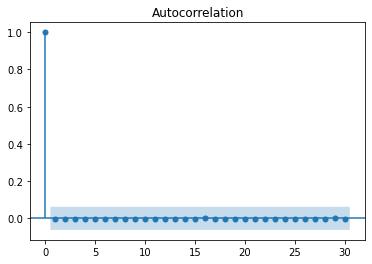

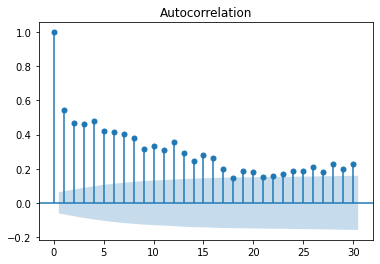

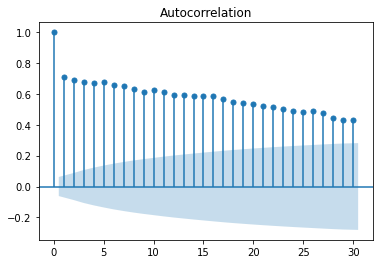

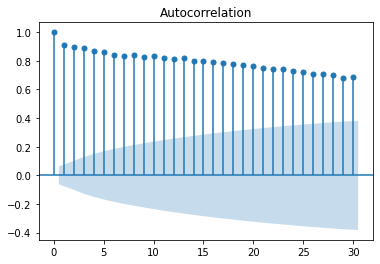

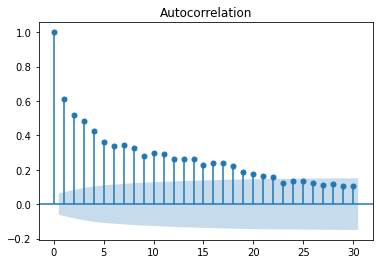

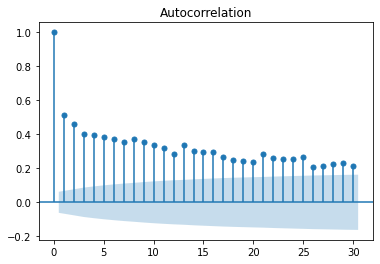

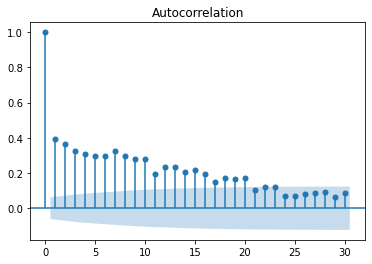

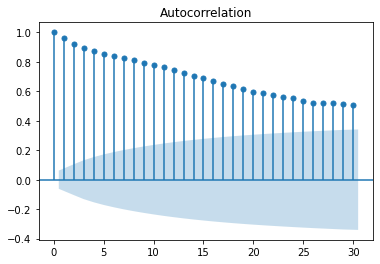

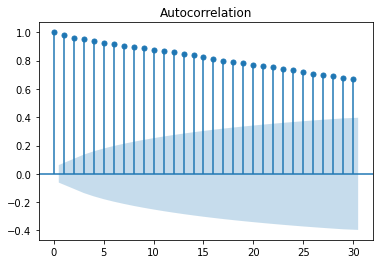

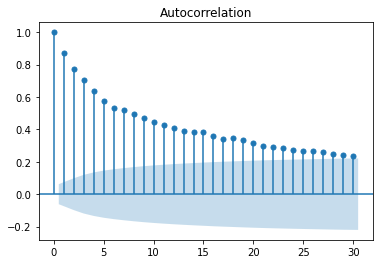

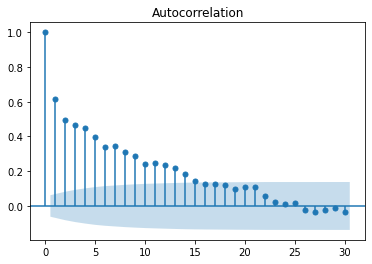

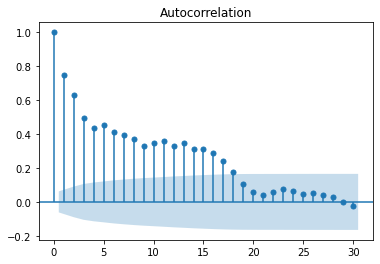

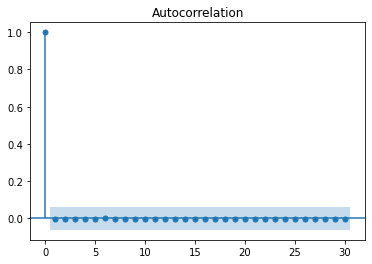

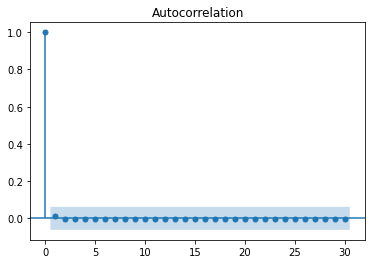

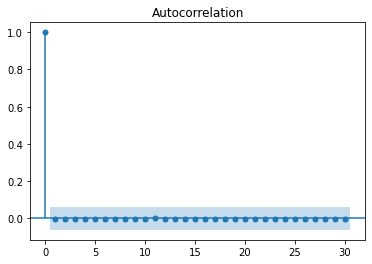

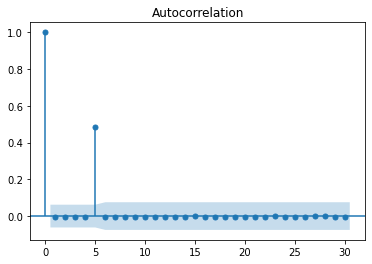

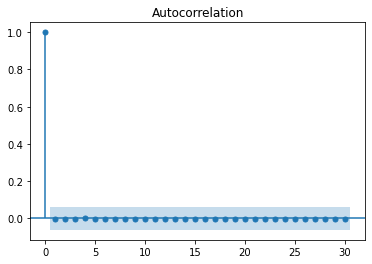

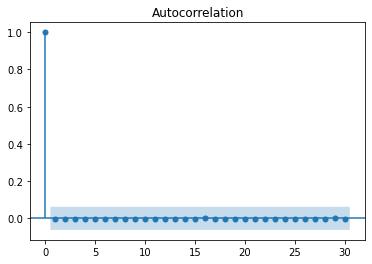

In [62]:
plot_acf(mchain4[0,499000:])
plot_acf(mchain4[1,499000:])
plot_acf(mchain4[2,499000:])
plot_acf(mchain4[3,499000:])
plot_acf(mchain4[4,499000:])
plot_acf(mchain4[5,499000:])
plot_acf(mchain4[6,499000:])
plot_acf(mchain4[7,499000:])
plot_acf(mchain4[8,499000:])
plot_acf(mchain4[9,499000:])
plot_acf(mchain4[10,499000:])
plot_acf(mchain4[11,499000:])
plot_acf(mchain4[12,499000:])
plot_acf(mchain4[13,499000:])
plot_acf(mchain4[14,499000:])
plot_acf(mchain4[15,499000:])
plot_acf(mchain4[16,499000:])

In [109]:
def mhsampler_6changep(NUMIT=1000, dat=Y, init_T1=1, init_T2=1, init_T3 = 1,init_T4 = 1,init_T5 = 1,init_T6=1,init_T7=1,init_K1=1,init_K2 = 10, init_K3 =20, init_K4 = 30, init_K5=40,init_K6=43,init_B1=1, init_B2=1,init_B3=1,init_B4 =1, init_B5 = 1, init_B6 = 1, init_B7=1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((20, NUMIT))
# count number of accepted proposals (for k only)
    acc_1 = 0
    acc_2 = 0
    acc_3 = 0
    acc_4 = 0
    acc_5 = 0
    acc_6 = 0
    # starting values for markov chain
    mchain[:,0] = np.array([init_T1, init_T2, init_T3, init_T4, init_T5, init_T6,init_T7,init_K1, init_K2, init_K3,init_K4,init_K5,init_K6,init_B1, init_B2, init_B3, init_B4, init_B5,init_B6,init_B7])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currlambda_1 = mchain[0, i-1]
        currlambda_2 = mchain[1, i-1]
        currlambda_3 = mchain[2, i-1]
        currlambda_4 = mchain[3, i-1]
        currlambda_5 = mchain[4, i-1]
        currlambda_6 = mchain[5, i-1]
        currlambda_7 = mchain[6, i-1]
        currk_1 = mchain[7, i-1]
        currk_2 = mchain[8, i-1]
        currk_3 = mchain[9, i-1]
        currk_4 = mchain[10, i-1]
        currk_5 = mchain[11, i-1]
        currk_6 = mchain[12, i-1]
        currb1 = mchain[13, i-1]
        currb2 = mchain[14, i-1]
        currb3 = mchain[15, i-1]
        currb4 = mchain[16, i-1]
        currb5 = mchain[17, i-1]
        currb6 = mchain[18, i-1]
        currb7 = mchain[19, i-1]
        # sample from full conditional distribution of theta (Gibbs update)
        currlambda_1 = np.random.gamma(shape=sum(Y.iloc[:int(currk_1)])+0.5, scale=currb1/(currk_1*currb1 + 1))
        currlambda_2 = np.random.gamma(shape=sum(Y.iloc[int(currk_1):int(currk_2)])+0.5, scale=currb2/((currk_2-currk_1)*currb2+1))
        currlambda_3 = np.random.gamma(shape=sum(Y.iloc[int(currk_2):int(currk_3)])+0.5, scale=currb3/((currk_3 - currk_2)*currb3 + 1))
        currlambda_4 = np.random.gamma(shape=sum(Y.iloc[int(currk_3):int(currk_4)])+0.5, scale=currb4/((currk_4 - currk_3)*currb4 + 1))
        currlambda_5 = np.random.gamma(shape=sum(Y.iloc[int(currk_4):int(currk_5)])+0.5, scale=currb5/((currk_5 - currk_4)*currb5 + 1))
        currlambda_6 = np.random.gamma(shape=sum(Y.iloc[int(currk_5):int(currk_6)])+0.5, scale=currb6/((currk_6 - currk_5)*currb6 + 1))
        currlambda_7 = np.random.gamma(shape=sum(Y.iloc[int(currk_6):])+0.5, scale=currb7/((n - currk_6)*currb7 + 1))
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_1 = np.random.randint(1, currk_2)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk_1)])*log(currlambda_1) + sum(Y.iloc[int(propk_1):int(currk_2)])*log(currlambda_2) - propk_1*currlambda_1 
                     - (currk_2-propk_1)*currlambda_2 +log(1/(currk_3-currk_1))- (sum(Y.iloc[:int(currk_1)])*log(currlambda_1) + sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) 
                                               - currk_1*currlambda_1 - (currk_2-currk_1)*currlambda_2+log(1/(currk_3-propk_1))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_1 += 1
            currk_1 = propk_1
            

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_2 = np.random.randint(currk_1+1, currk_3)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_1):int(propk_2)])*log(currlambda_2) + sum(Y.iloc[int(propk_2):int(currk_3)])*log(currlambda_3) - propk_2*currlambda_2 
                     - (currk_3-propk_2)*currlambda_3 + log(1/(currk_4 -currk_2))+log(1/(currk_2)) - (sum(Y.iloc[int(currk_1):int(currk_2)])*log(currlambda_2) + sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) 
                                               - currk_2*currlambda_2 - (currk_3-currk_2)*currlambda_3+log(1/(currk_4 - propk_2))+log(1/(propk_2))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_2 += 1
            currk_2 = propk_2

    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_3 = np.random.randint(currk_2+1, currk_4)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_2):int(propk_3)])*log(currlambda_3) + sum(Y.iloc[int(propk_3):int(currk_4)])*log(currlambda_4) - propk_3*currlambda_3 
                     - (currk_4-propk_3)*currlambda_4 - (sum(Y.iloc[int(currk_2):int(currk_3)])*log(currlambda_3) + sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) 
                                               - currk_3*currlambda_3 - (currk_4-currk_3)*currlambda_4))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_3 += 1
            currk_3 = propk_3
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_4 = np.random.randint(currk_3+1, currk_5)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_3):int(propk_4)])*log(currlambda_5) + sum(Y.iloc[int(propk_4):int(currk_5)])*log(currlambda_5) - propk_4*currlambda_4 
                     - (currk_5-propk_4)*currlambda_5 +log(1/(currk_4-currk_2))+log(1/(45-currk_4))- (sum(Y.iloc[int(currk_3):int(currk_4)])*log(currlambda_4) + sum(Y.iloc[int(currk_4):int(currk_5)])*log(currlambda_5) 
                                               - currk_4*currlambda_4 - (currk_5-currk_4)*currlambda_5+log(1/(propk_4-currk_2))+log(1/(45-propk_4))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_4 += 1
            currk_4 = propk_4
            
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_5 = np.random.randint(currk_4+1, currk_6)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_4):int(propk_5)])*log(currlambda_6) + sum(Y.iloc[int(propk_5):int(currk_6)])*log(currlambda_6) - propk_5*currlambda_5 
                     - (currk_6-propk_5)*currlambda_6+log(1/(currk_5- currk_3)) - (sum(Y.iloc[int(currk_4):int(currk_5)])*log(currlambda_5) + sum(Y.iloc[int(currk_5):int(currk_6)])*log(currlambda_6) 
                                               - currk_5*currlambda_5 - (currk_6-currk_5)*currlambda_6+log(1/(propk_5- currk_3))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_5 += 1
            currk_5 = propk_5
            
    # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk_6 = np.random.randint(currk_5+1, 45)  # draw one sample at random from uniform{1,...,n-1}
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[int(currk_5):])*log(currlambda_7) + sum(Y.iloc[int(propk_6):])*log(currlambda_7) - propk_6*currlambda_6 
                     - (n-propk_6)*currlambda_7+log(1/(currk_6- currk_4)) - (sum(Y.iloc[int(currk_5):int(currk_6)])*log(currlambda_6) + sum(Y.iloc[int(currk_6):])*log(currlambda_7) 
                                               - currk_6*currlambda_6 - (n-currk_6)*currlambda_7+log(1/(propk_6- currk_4))))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_6 += 1
            currk_6 = propk_6
            
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_1+1))
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_2+1))
        currb3 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_3+1))
        currb4 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_4+1))
        currb5 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_5+1))
        currb6 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_6+1))
        currb7 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda_7+1))
        
        # update chain with new values
        mchain[:,i] = np.array([currlambda_1, currlambda_2,currlambda_3,currlambda_4,currlambda_5,currlambda_6,currlambda_7,currk_1,currk_2, currk_3,currk_4,currk_5,currk_6,currb1, currb2, currb3, currb4, currb5, currb6,currb7])
        
    return mchain

In [117]:
mchain5 = mhsampler_6changep(NUMIT = 500000)

n= 46


In [121]:
print("Mean of row (theta) is now", np.mean(mchain5[0,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[1,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[2,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[3,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[4,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[5,499500:]))
print("Mean of row (theta)is now", np.mean(mchain5[6,499500:]))
print("Mean of row cps is now", np.mean(mchain5[7,499500:]))
print("Mean of row cps is now", np.mean(mchain5[8,499500:]))
print("Mean of row cps is now", np.mean(mchain5[9,499500:]))
print("Mean of row cps is now", np.mean(mchain5[10,499500:]))
print("Mean of row cps is now", np.mean(mchain5[11,499500:]))
print("Mean of row cps is now", np.mean(mchain5[12,499500:]))
print("Mean of row b is now", np.mean(mchain5[13,499000:]))
print("Mean of row b is now", np.mean(mchain5[14,499000:]))
print("Mean of row b is now", np.mean(mchain5[15,499000:]))
print("Mean of row b is now", np.mean(mchain5[16,499000:]))
print("Mean of row b is now", np.mean(mchain5[17,499000:]))
print("Mean of row b is now", np.mean(mchain5[18,499000:]))
print("Mean of row b is now", np.mean(mchain5[19,499000:]))

print("Median of row (theta) is now", np.median(mchain5[0,495000:]))
print("Median of row (theta)is now", np.median(mchain5[1,495000:]))
print("Median of row (theta)is now", np.median(mchain5[2,495000:]))
print("Median of row (theta)is now", np.median(mchain5[3,495000:]))
print("Median of row (theta)is now", np.median(mchain5[4,495000:]))
print("Median of row (theta)is now", np.median(mchain5[5,495000:]))
print("Median of row cps is now", np.median(mchain5[6,495000:]))
print("Median of row cps is now", np.median(mchain5[7,495000:]))
print("Median of row cps is now", np.median(mchain5[8,495000:]))
print("Median of row cps is now", np.median(mchain5[9,495000:]))
print("Median of row cps is now", np.median(mchain5[10,495000:]))
print("Median of row b is now", np.median(mchain5[11,495000:]))
print("Median of row b is now", np.median(mchain5[12,495000:]))
print("Median of row b is now", np.median(mchain5[13,495000:]))
print("Median of row b is now", np.median(mchain5[14,495000:]))
print("Median of row b is now", np.median(mchain5[15,495000:]))
print("Median of row b is now", np.median(mchain5[16,495000:]))
y5 = np.apply_along_axis(np.mean, 1, mchain5[:,499000:])

Mean of row (theta) is now 9.191233087542631
Mean of row (theta)is now 4.95707317258655
Mean of row (theta)is now 19.43532240124483
Mean of row (theta)is now 7.430237559943872
Mean of row (theta)is now 7.712389405951739
Mean of row (theta)is now 8.734938625346924
Mean of row (theta)is now 7.9059449134479465
Mean of row cps is now 2.46
Mean of row cps is now 10.024
Mean of row cps is now 13.012
Mean of row cps is now 21.908
Mean of row cps is now 29.896
Mean of row cps is now 37.416
Mean of row b is now 328236.1831858348
Mean of row b is now 10193.109206561909
Mean of row b is now 17457607.785520744
Mean of row b is now 138711.02028193956
Mean of row b is now 218989903.9393794
Mean of row b is now 235179.73479948967
Mean of row b is now 311891.1725599096
Median of row (theta) is now 6.871517634272477
Median of row (theta)is now 5.491007651784299
Median of row (theta)is now 18.208990086605418
Median of row (theta)is now 7.722473485214044
Median of row (theta)is now 8.209781789759312
Medi

[6.12498257e+00 9.23382962e+00 8.33685612e+00 8.82492000e+00
 2.79288800e+01 2.28553771e+07 1.32322356e+06 1.36481390e+07]
[6.44359397e+00 9.26722528e+00 8.99580394e+00 7.98408121e+00
 8.12375000e+00 2.17704400e+01 3.50992300e+01 1.73459789e+07
 2.07000063e+06 2.87755375e+07 1.84603419e+08]
[6.13934061e+00 1.75186338e+01 9.27661378e+00 9.87677559e+00
 6.11749784e+00 9.04610000e+00 1.25814120e+01 2.77972260e+01
 4.12166620e+01 1.40133414e+07 1.76902366e+07 1.14192847e+10
 1.33269957e+08 1.76209287e+08]
[8.28787033e+00 5.59893953e+00 2.02041060e+01 7.54895408e+00
 9.17998621e+00 6.39460407e+00 3.18200000e+00 1.02300000e+01
 1.30060000e+01 2.69420000e+01 4.04460000e+01 8.66968464e+03
 1.87159130e+07 6.51489520e+04 1.85900250e+08 5.13982132e+04
 3.31650167e+05]
[8.76683628e+00 5.79150932e+00 2.00340664e+01 7.48226308e+00
 7.77864387e+00 8.24121734e+00 7.83118741e+00 3.10400000e+00
 1.01700000e+01 1.30150000e+01 2.24800000e+01 3.09490000e+01
 3.79580000e+01 3.28236183e+05 1.01931092e+04 1.7

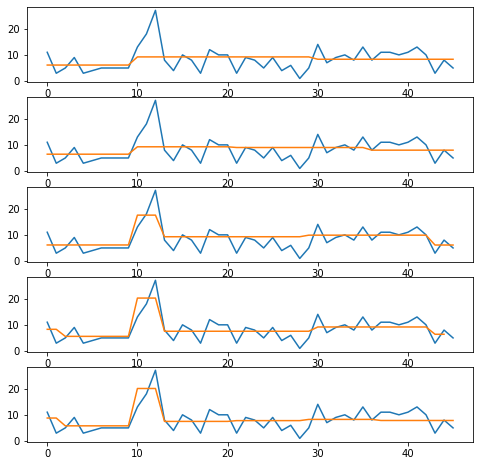

In [124]:
plt.figure(figsize=(8,8))
plt.subplot(511)
plt.plot(Y)
print(y1)
temp1 = np.array([y1[0] for i in range(10)])
temp2 = np.array([y1[1] for i in range(20)])
temp3 = np.array([y1[2] for i in range(16)])
n = np.append(temp1, temp2)
n = np.append(n,temp3)
plt.plot(n)
plt.subplot(512)
plt.plot(Y)
print(y2)
temp1 = np.array([y2[0] for i in range(10)])
temp2 = np.array([y2[1] for i in range(11)])
temp3 = np.array([y2[2] for i in range(15)])
temp4 = np.array([y2[3] for i in range(10)])
n = np.append(temp1, temp2)
n = np.append(n,temp3)
n = np.append(n, temp4)
plt.plot(n)
plt.subplot(513)
plt.plot(Y)
print(y3)
temp1 = np.array([y3[0] for i in range(10)])
temp2 = np.array([y3[1] for i in range(3)])
temp3 = np.array([y3[2] for i in range(16)])
temp4 = np.array([y3[3] for i in range(14)])
temp5 = np.array([y3[4] for i in range(3)])
n = np.append(temp1, temp2)
n = np.append(n,temp3)
n = np.append(n, temp4)
n = np.append(n, temp5)
plt.plot(n)
plt.subplot(514)
plt.plot(Y)
print(y4)
temp1 = np.array([y4[0] for i in range(2)])
temp2 = np.array([y4[1] for i in range(8)])
temp3 = np.array([y4[2] for i in range(3)])
temp4 = np.array([y4[3] for i in range(17)])
temp5 = np.array([y4[4] for i in range(13)])
temp6 = np.array([y4[5] for i in range(2)])
n = np.append(temp1, temp2)
n = np.append(n,temp3)
n = np.append(n, temp4)
n = np.append(n, temp5)
n = np.append(n, temp6)
plt.plot(n)
plt.subplot(515)
plt.plot(Y)
print(y5)
temp1 = np.array([y5[0] for i in range(2)])
temp2 = np.array([y5[1] for i in range(8)])
temp3 = np.array([y5[2] for i in range(3)])
temp4 = np.array([y5[3] for i in range(8)])
temp5 = np.array([y5[4] for i in range(8)])
temp6 = np.array([y5[5] for i in range(8)])
temp7 = np.array([y5[6] for i in range(9)])
n = np.append(temp1, temp2)
n = np.append(n,temp3)
n = np.append(n, temp4)
n = np.append(n, temp5)
n = np.append(n, temp6)
n = np.append(n, temp7)
plt.plot(n)